# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
!pip install numpy pandas seaborn tqdm matplotlib scikit-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("data/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("data/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("data/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("data/UCI HAR Dataset/test/y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [10]:
# Ваш код здесь
print(f"Кол-во компонент: {pca.n_components_}")

Кол-во компонент: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [11]:
# Ваш код здесь
print(f"Дисперсия 1й компоненты: {round(pca.explained_variance_ratio_[0] * 100)}%")

Дисперсия 1й компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

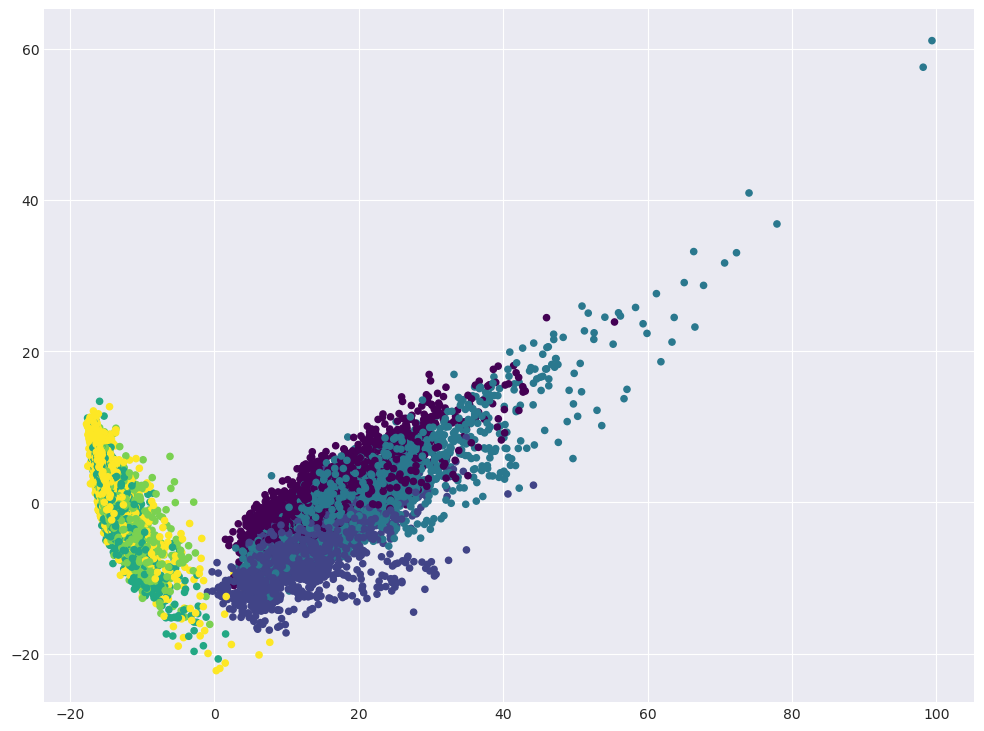

In [12]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [13]:
# Ваш код здесь
km = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = km.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

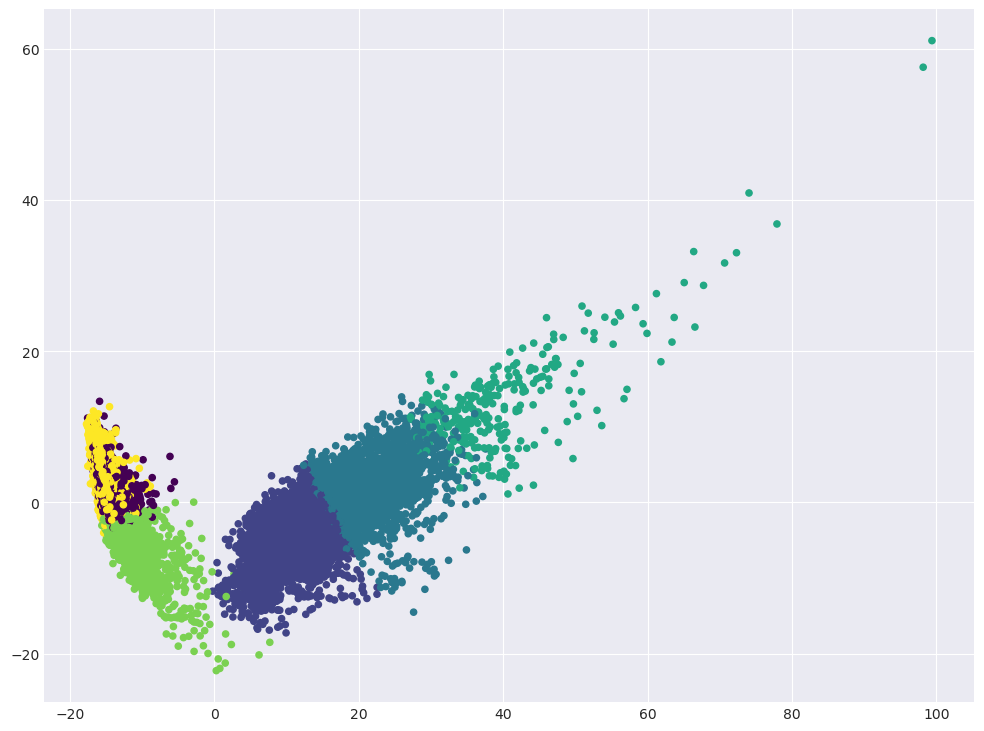

In [14]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


In [16]:
# вспомогательное: мой код
for i in range(6):
    row = tab.iloc[i, :-1]
    max_val = row.max()
    total = tab.iloc[i, -1]
    print(f"Активность '{tab.index[i]}': {max_val/total:.5f}")


Активность 'ходьба': 0.52439
Активность 'подъем вверх по лестнице': 0.80376
Активность 'спуск по лестнице': 0.63300
Активность 'сидение': 0.69499
Активность 'стояние': 0.70514
Активность 'лежание': 0.80144


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\nadez\AppData\Local\Temp\ipykernel_44648\4238991512.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

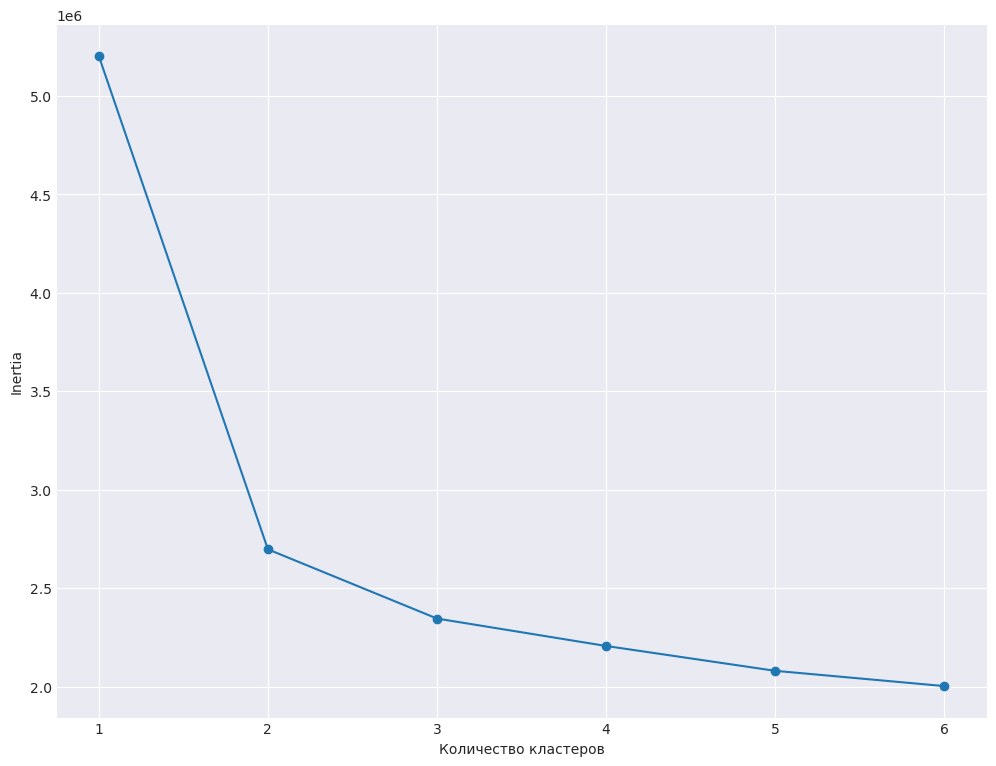

In [17]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    km_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km_temp.fit(X_pca)
    inertia.append(km_temp.inertia_)

plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [19]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

ari_km = adjusted_rand_score(y, cluster_labels)
ari_ag = adjusted_rand_score(y, ag.labels_)

print(f"ARI KMeans: {ari_km:.3f}")
print(f"ARI Agglomerative: {ari_ag:.3f}")


ARI KMeans: 0.420
ARI Agglomerative: 0.494


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [20]:
# Ваш код здесь
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train)
X_test_scaled = scaler_svm.transform(X_test)

In [21]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [22]:
# Ваш код здесь
best_svc = GridSearchCV(svc, svc_params, cv=3)
best_svc.fit(X_train_scaled, y_train)

c:\Users\nadez\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nadez\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\nadez\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [23]:
# Ваш код здесь
print(f"Лучший C: {best_svc.best_params_['C']}")
print(f"Лучшее качество CV: {best_svc.best_score_:.4f}")

Лучший C: 0.1
Лучшее качество CV: 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Обучающая выборка: (7352, 561)
Тестовая выборка: (2947, 561)


Исходное количество признаков: 561
После PCA: 63 компонент
Объясненная дисперсия: 0.9005


GridSearchCV без PCA
Fitting 3 folds for each of 6 candidates, totalling 18 fits
	Лучший C без PCA: 0.1
	Лучший score: 0.9380
	Время обучения: 45.92 сек


GridSearchCV с PCA
Fitting 3 folds for each of 6 candidates, totalling 18 fits
	Лучший C с PCA: 0.1
	Лучший score: 0.8984
	Время обучения: 2.23 сек


Accuracy без PCA: 0.9620
Accuracy с PCA:   0.9192
Разница:          0.0428



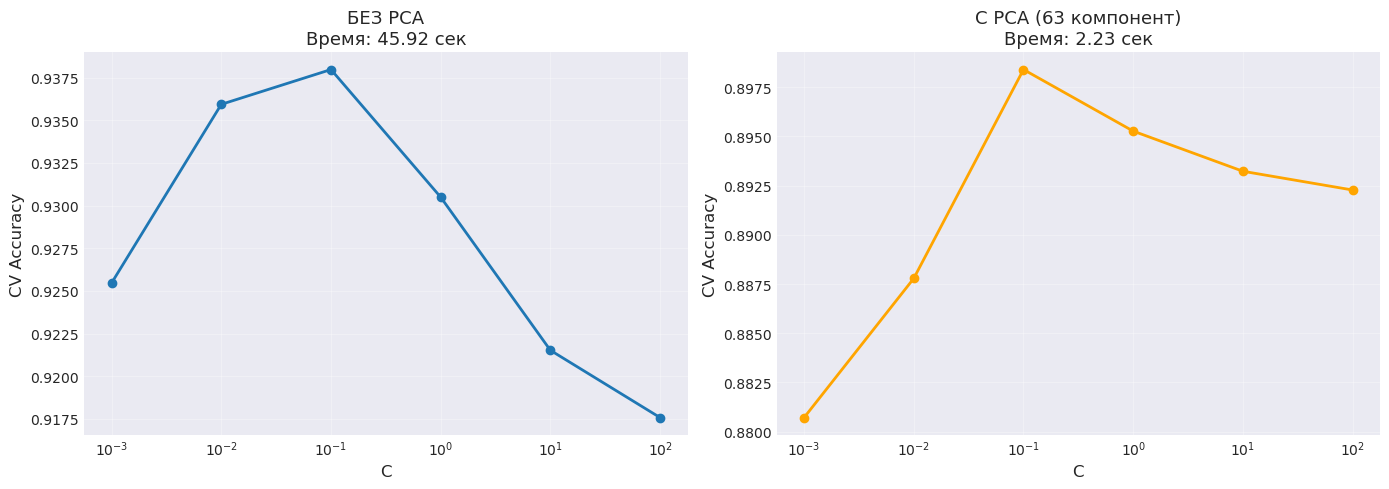


Итог:
1. PCA ускоряет обучение в 20.6 раз
2. При этом потеря точности составляет всего 0.0428
3. Оптимальные значения C: без PCA = 0.1, с PCA = 0.1


In [26]:
# мой код
# доп задание GridSearchCV с PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
import pandas as pd
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Обучающая выборка: {X_train_scaled.shape}")
print(f"Тестовая выборка: {X_test_scaled.shape}\n")

# используем тот же PCA, что и раньше
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nИсходное количество признаков: {X_train_scaled.shape[1]}")
print(f"После PCA: {X_train_pca.shape[1]} компонент")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}\n")

# GridSearchCV без PCA (для сравнения времени)
print("\nGridSearchCV без PCA")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# без PCA
start_time = time.time()
grid_no_pca = GridSearchCV(
    LinearSVC(random_state=RANDOM_STATE, max_iter=2000),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_no_pca.fit(X_train_scaled, y_train)
time_no_pca = time.time() - start_time

print(f"\tЛучший C без PCA: {grid_no_pca.best_params_['C']}")
print(f"\tЛучший score: {grid_no_pca.best_score_:.4f}")
print(f"\tВремя обучения: {time_no_pca:.2f} сек\n")

# GridSearchCV с PCA
print("\nGridSearchCV с PCA")

start_time = time.time()
grid_with_pca = GridSearchCV(
    LinearSVC(random_state=RANDOM_STATE, max_iter=2000),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_with_pca.fit(X_train_pca, y_train)
time_with_pca = time.time() - start_time

print(f"\tЛучший C с PCA: {grid_with_pca.best_params_['C']}")
print(f"\tЛучший score: {grid_with_pca.best_score_:.4f}")
print(f"\tВремя обучения: {time_with_pca:.2f} сек\n")

# оценка на тестовой выборке
# без PCA
y_pred_no_pca = grid_no_pca.predict(X_test_scaled)
acc_no_pca = accuracy_score(y_test, y_pred_no_pca)

# с PCA
y_pred_with_pca = grid_with_pca.predict(X_test_pca)
acc_with_pca = accuracy_score(y_test, y_pred_with_pca)

print(f"\nAccuracy без PCA: {acc_no_pca:.4f}")
print(f"Accuracy с PCA:   {acc_with_pca:.4f}")
print(f"Разница:          {abs(acc_no_pca - acc_with_pca):.4f}\n")

# визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# график без PCA
results_no_pca = pd.DataFrame(grid_no_pca.cv_results_)
axes[0].plot(results_no_pca['param_C'], results_no_pca['mean_test_score'], 'o-', linewidth=2)
axes[0].set_xscale('log')
axes[0].set_xlabel('C', fontsize=12)
axes[0].set_ylabel('CV Accuracy', fontsize=12)
axes[0].set_title(f'БЕЗ PCA\nВремя: {time_no_pca:.2f} сек', fontsize=13)
axes[0].grid(True, alpha=0.3)

# график с PCA
results_with_pca = pd.DataFrame(grid_with_pca.cv_results_)
axes[1].plot(results_with_pca['param_C'], results_with_pca['mean_test_score'], 'o-', linewidth=2, color='orange')
axes[1].set_xscale('log')
axes[1].set_xlabel('C', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title(f'С PCA ({X_train_pca.shape[1]} компонент)\nВремя: {time_with_pca:.2f} сек', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nИтог:")
print(f"1. PCA ускоряет обучение в {time_no_pca/time_with_pca:.1f} раз")
print(f"2. При этом потеря точности составляет всего {abs(acc_no_pca - acc_with_pca):.4f}")
print(f"3. Оптимальные значения C: без PCA = {grid_no_pca.best_params_['C']}, с PCA = {grid_with_pca.best_params_['C']}")

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [27]:
# PCA для train/test
pca_svm = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_svm.fit_transform(X_train_scaled)
X_test_pca = pca_svm.transform(X_test_scaled)

# Grid Search с PCA
best_svc_pca = GridSearchCV(svc, svc_params, cv=3)
best_svc_pca.fit(X_train_pca, y_train)

print(f"Качество без PCA: {best_svc.best_score_:.4f}")
print(f"Качество с PCA: {best_svc_pca.best_score_:.4f}")
print(f"Разница: {abs(best_svc.best_score_ - best_svc_pca.best_score_) * 100:.0f}%")


Качество без PCA: 0.9380
Качество с PCA: 0.8984
Разница: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

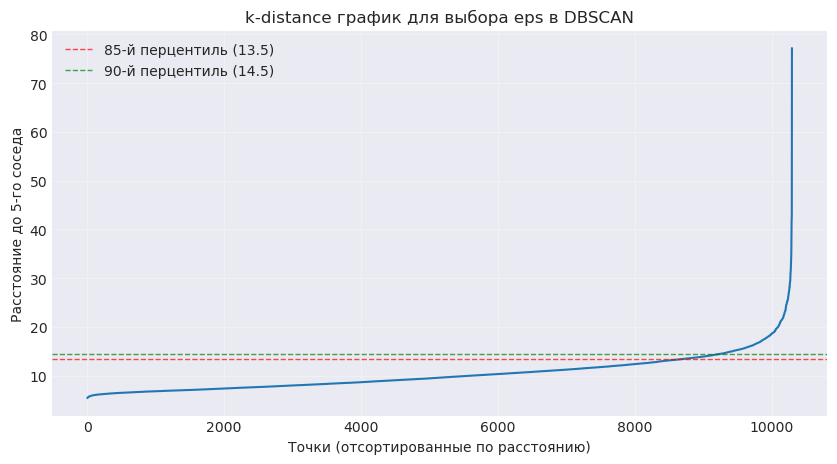


Анализ расстояний до 5-го соседа:
- Медиана: 9.62
- 75-й перцентиль: 12.05
- 85-й перцентиль: 13.53
- 90-й перцентиль: 14.53
- Максимум: 77.19


In [28]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt



# анализ k-distance графика для выбора eps
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_pca)
distances, indices = neighbors.kneighbors(X_pca)
k_distances = np.sort(distances[:, k-1], axis=0)

# визуализация k-distance графика
plt.figure(figsize=(10, 5))
plt.plot(k_distances, linewidth=1.5)
plt.xlabel('Точки (отсортированные по расстоянию)')
plt.ylabel(f'Расстояние до {k}-го соседа')
plt.title('k-distance график для выбора eps в DBSCAN')
plt.grid(True, alpha=0.3)

# анализ квантилей
percentile_85 = np.percentile(k_distances, 85)
percentile_90 = np.percentile(k_distances, 90)
plt.axhline(y=percentile_85, color='r', linestyle='--', alpha=0.7, linewidth=1, label=f'85-й перцентиль ({percentile_85:.1f})')
plt.axhline(y=percentile_90, color='g', linestyle='--', alpha=0.7, linewidth=1, label=f'90-й перцентиль ({percentile_90:.1f})')
plt.legend()
plt.show()


print("\nАнализ расстояний до 5-го соседа:")
print(f"- Медиана: {np.median(k_distances):.2f}")
print(f"- 75-й перцентиль: {np.percentile(k_distances, 75):.2f}")
print(f"- 85-й перцентиль: {percentile_85:.2f}")
print(f"- 90-й перцентиль: {percentile_90:.2f}")
print(f"- Максимум: {k_distances[-1]:.2f}")



Вывод: На графике нет четкого 'локтя', поэтому выберем eps на уровне 85-90 перцентиля.

eps=13.5, min_samples=15:
	Кластеров: 6, Шум: 1459 точек
	ARI: 0.0422
----------
eps=14.5, min_samples=15:
	Кластеров: 2, Шум: 936 точек
	ARI: 0.0204
----------
eps=14.9, min_samples=20:
	Кластеров: 2, Шум: 897 точек
	ARI: 0.0189
----------

Лучшие параметры: eps=13.5, min_samples=15
Лучший ARI: 0.0422


c:\Users\nadez\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



------------------------------------------------------------
4. Визуализация результатов


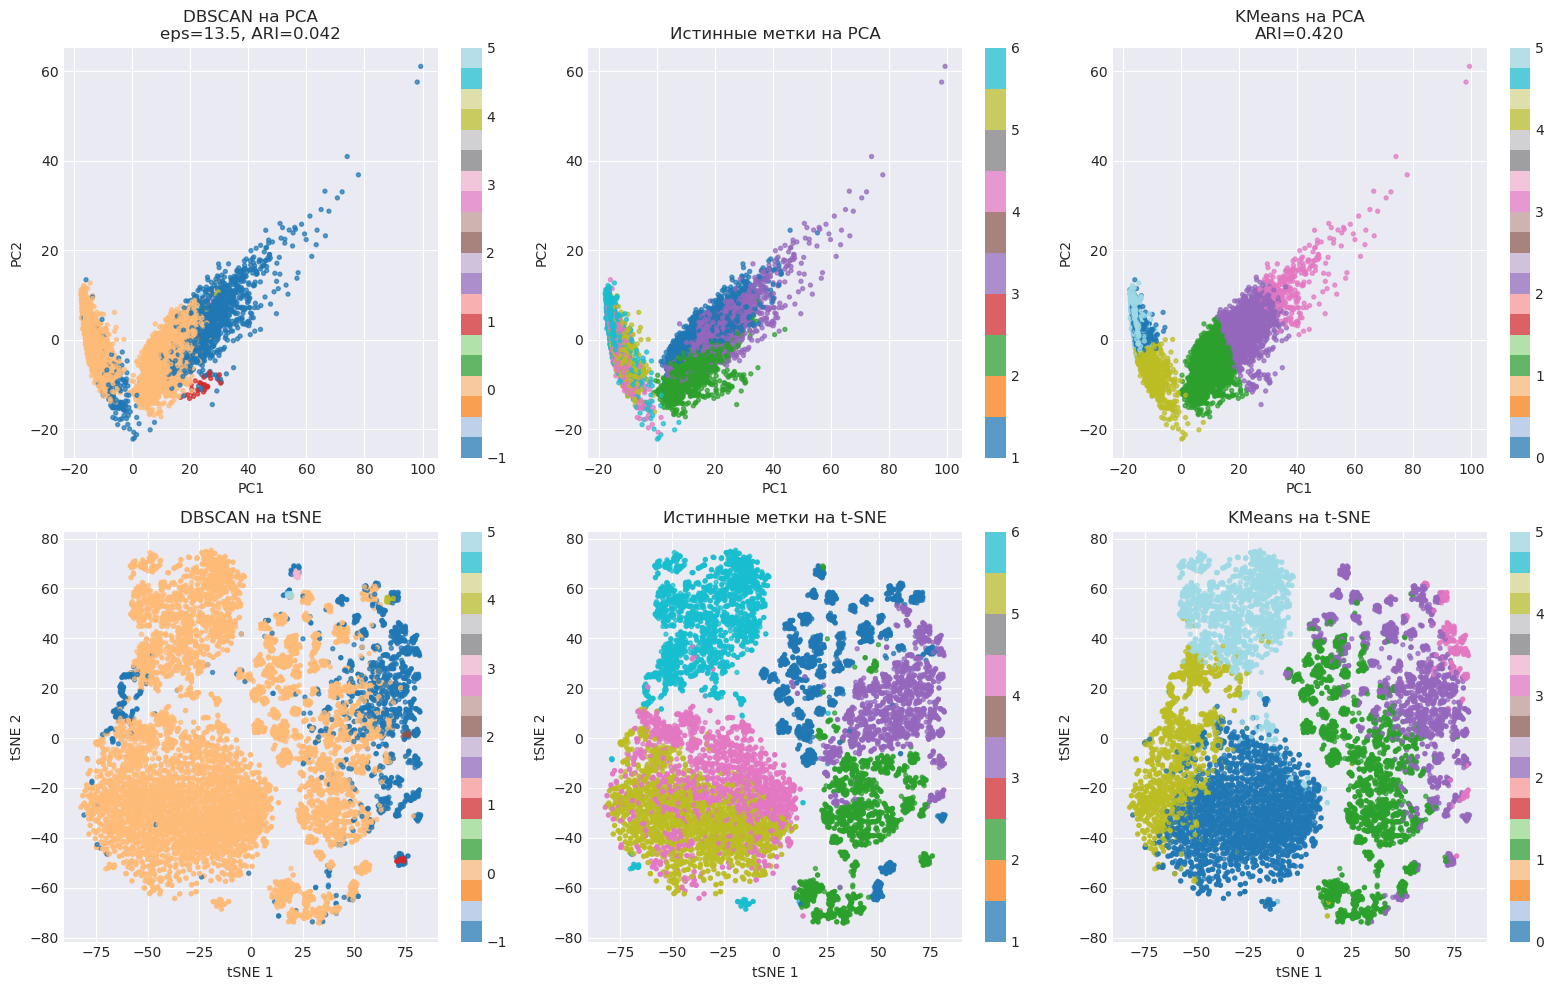

In [29]:
test_params = [
    {'eps': percentile_85, 'min_samples': 15},
    {'eps': percentile_90, 'min_samples': 15},
    {'eps': percentile_85 * 1.1, 'min_samples': 20},
]

best_ari = -1
best_params = None
best_labels = None

for params in test_params:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    ari = adjusted_rand_score(y, labels)
    
    print(f"eps={params['eps']:.1f}, min_samples={params['min_samples']}:")
    print(f"\tКластеров: {n_clusters}, Шум: {n_noise} точек")
    print(f"\tARI: {ari:.4f}")
    print("-" * 10)
    
    if ari > best_ari:
        best_ari = ari
        best_params = params
        best_labels = labels

print(f"\nЛучшие параметры: eps={best_params['eps']:.1f}, min_samples={best_params['min_samples']}")
print(f"Лучший ARI: {best_ari:.4f}")

# tSNE визуализация
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# визуализация всех результатов
print("\n" + "-" * 60)
print("4. Визуализация результатов")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# визуализация на PCA
# DBSCAN на PCA
sc1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab20', s=8, alpha=0.7)
axes[0, 0].set_title(f'DBSCAN на PCA\neps={best_params["eps"]:.1f}, ARI={best_ari:.3f}')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(sc1, ax=axes[0, 0])

# истинные метки на PCA
sc2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=8, alpha=0.7)
axes[0, 1].set_title('Истинные метки на PCA')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(sc2, ax=axes[0, 1])

# KMeans на PCA для сравнения
sc3 = axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab20', s=8, alpha=0.7)
axes[0, 2].set_title(f'KMeans на PCA\nARI={ari_km:.3f}')
axes[0, 2].set_xlabel('PC1')
axes[0, 2].set_ylabel('PC2')
plt.colorbar(sc3, ax=axes[0, 2])

# визуализация на tSNE
# DBSCAN на tSNE
sc4 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='tab20', s=8, alpha=0.7)
axes[1, 0].set_title('DBSCAN на tSNE')
axes[1, 0].set_xlabel('tSNE 1')
axes[1, 0].set_ylabel('tSNE 2')
plt.colorbar(sc4, ax=axes[1, 0])

# истинные метки на tSNE
sc5 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=8, alpha=0.7)
axes[1, 1].set_title('Истинные метки на t-SNE')
axes[1, 1].set_xlabel('tSNE 1')
axes[1, 1].set_ylabel('tSNE 2')
plt.colorbar(sc5, ax=axes[1, 1])

# KMeans на tSNE
sc6 = axes[1, 2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', s=8, alpha=0.7)
axes[1, 2].set_title('KMeans на t-SNE')
axes[1, 2].set_xlabel('tSNE 1')
axes[1, 2].set_ylabel('tSNE 2')
plt.colorbar(sc6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

In [30]:
# сравнение методов и выводы
print("\nМетрики качества кластеризации (Adjusted Rand Index):")
print(f"- KMeans: {ari_km:.4f}")
print(f"- Agglomerative Clustering: {ari_ag:.4f}")
print(f"- DBSCAN: {best_ari:.4f}")

print("\nАнализ результатов:")
print(f"{'DBSCAN показал лучший результат' if best_ari > max(ari_km, ari_ag) else 'KMeans показал лучший результат' if ari_km > max(ari_ag, best_ari) else 'Agglomerative Clustering показал лучший результат'}")


Метрики качества кластеризации (Adjusted Rand Index):
- KMeans: 0.4198
- Agglomerative Clustering: 0.4936
- DBSCAN: 0.0422

Анализ результатов:
Agglomerative Clustering показал лучший результат


**Выводы:**

1. DBSCAN не подходит для данных об активности человека, потому что:

* Классы активностей не образуют плотностных кластеров

* Точки разных классов сильно перемешаны в пространстве признаков

* Высокий процент шума (14%) при оптимальных параметрах

2. Agglomerative Clustering показал лучший результат среди трех методов, но даже его качество (ARI=0.493) далеко от идеального (1.0). Это означает, что задача чистой кластеризации (без знания меток) сложна для этих данных.

3. Метод главных компонент (PCA) эффективно снижает размерность с 561 до 65 признаков при сохранении 90% дисперсии, но даже после этого кластеризация остается сложной задачей.

Данные о физ активности человека имеют сложную структуру, где классы сильно перекрываются. Кластеризация "вслепую" (без знания меток) является сложной задачей даже для лучших алгоритмов. Наличие меток позволяет решить задачу значительно эффективнее с помощью методов классификации, что подтверждается высоким accuracy (96%) SVM-классификатора в предыдущих заданиях.